In [1]:
from _element import feature_control as ft_c

In [2]:
from _element import calculations as calc

In [3]:
from _usecase import algorithm_prophet as prpt

In [4]:
import pandas as pd

In [5]:
from datetime import datetime

In [6]:
from _element import varr

In [7]:
INPUT_FILENAME= 'KPP일별투입(10_17)_raw.xlsx'

In [8]:
df_raw= ft_c.xlsx_opener(varr.PJ_DIR+varr.DF_DIR, INPUT_FILENAME)

In [9]:
df_temp= ft_c.xlsx_opener(varr.PJ_DIR+varr.TEMP_DATA_DIR, 'temp_data_merged.xlsx')

In [10]:
y_col= df_raw.columns.values.tolist()

In [11]:
try:
    y_col.remove('ds')
except ValueError:
    pass

In [12]:
y_col

['y']

In [13]:
x_col= df_temp.columns.values.tolist()

In [14]:
x_col

['ds', 'temp_max', 'temp_min', 'rain_amount']

In [15]:
df_raw['ds']= pd.to_datetime(df_raw['ds'], box=True, format= '%Y/%m/%d', exact=True)

In [16]:
df_temp['ds']= pd.to_datetime(df_temp['ds'], box=True, format= '%Y/%m/%d', exact=True)

In [17]:
df_raw= pd.merge(df_raw, df_temp, how='inner', on='ds')

In [19]:
result_dict= {}
for y in y_col:
    result_dict[y]= prpt.Bayseian2(df_raw, varr.FORECASTDAY, y, x_col, 'day')
    result_dict[y]['forecastProphetTable']['weekday']= result_dict[y]['forecastProphetTable']['ds'].apply(lambda x: x.weekday())
    result_dict[y]['forecastProphetTable']['weekday'].replace([0,1,2,3,4,5,6], [1, 1, 1, 1, 1, 0.734814572, 0.005993335], inplace= True)
    result_dict[y]['forecastProphetTable']['yhat']= result_dict[y]['forecastProphetTable']['weekday']*result_dict[y]['forecastProphetTable']['yhat']
    result_dict[y]['forecastProphetTable'].drop('weekday', axis=1, inplace= True)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.


In [20]:
forecast_dict= {}
print(INPUT_FILENAME)
for y in y_col:
    result_dict[y]['future']['ds']= pd.to_datetime(result_dict[y]['future']['ds'], box=True, format= '%Y/%m/%d', exact=True)
    result_dict[y]['forecastProphetTable']['ds']= pd.to_datetime(result_dict[y]['forecastProphetTable']['ds'], box=True, format= '%Y/%m/%d', exact=True)
    forecast_dict[y]= prpt.extract_info_from(result_dict[y]['future'], result_dict[y]['forecastProphetTable'], varr.FORECASTDAY)
    forecast_dict[y]['result_df']= pd.merge(forecast_dict[y]['result_df'], df_raw[['ds', y]], how='inner', on='ds')
    print('RMSE with segment '+str(y)+': '+str(calc.rms_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE with segment '+str(y)+': '+str(calc.map_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE_with_std with segment '+str(y)+': '+str(calc.map_error_with_std(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE_div_std with segment '+str(y)+': '+str(calc.map_error_div_std(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('sMAPE of company code '+str(y)+': '+str(calc.smap_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print(forecast_dict[y]['result_df'].head())
    ft_c.save_as_xlsx(varr.PJ_DIR+varr.DF_DIR, forecast_dict[y]['result_df'], INPUT_FILENAME, '_seg'+str(y)+'withoutweekday')
    print('\n')

KPP일별투입(10_17)_raw.xlsx
RMSE with segment y: 6847.59936586
MAPE with segment y: 9.63375112423
MAPE_with_std with segment y: 21.2408895845
MAPE_div_std with segment y: 100.404205541
sMAPE of company code y: 2.80014540705
          ds   temp_max  temp_min  rain_amount           yhat       y
0 2017-11-01  17.299999      13.4          0.0  119823.390834  127688
1 2017-11-02  18.000000      14.0          1.6  117300.587991  132155
2 2017-11-03  15.700000       4.5          0.6  121105.981224  133493
3 2017-11-04  12.800000       3.2          0.0   56842.864333   65514
4 2017-11-05  14.200000       7.3          0.0     130.903058     105




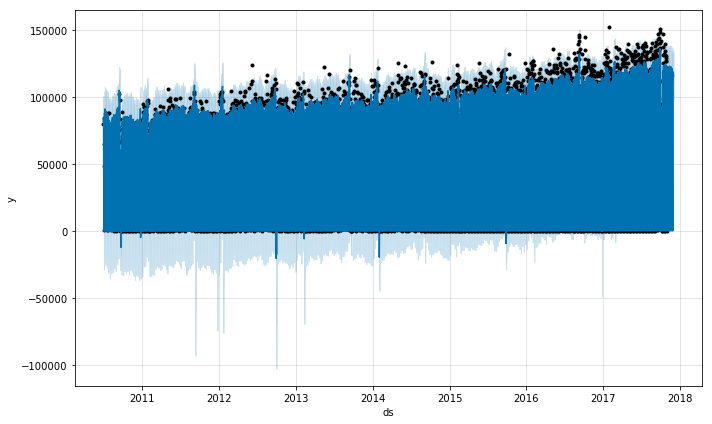

In [21]:
result_dict['y']['model'].plot(result_dict['y']['forecastProphetTable'])

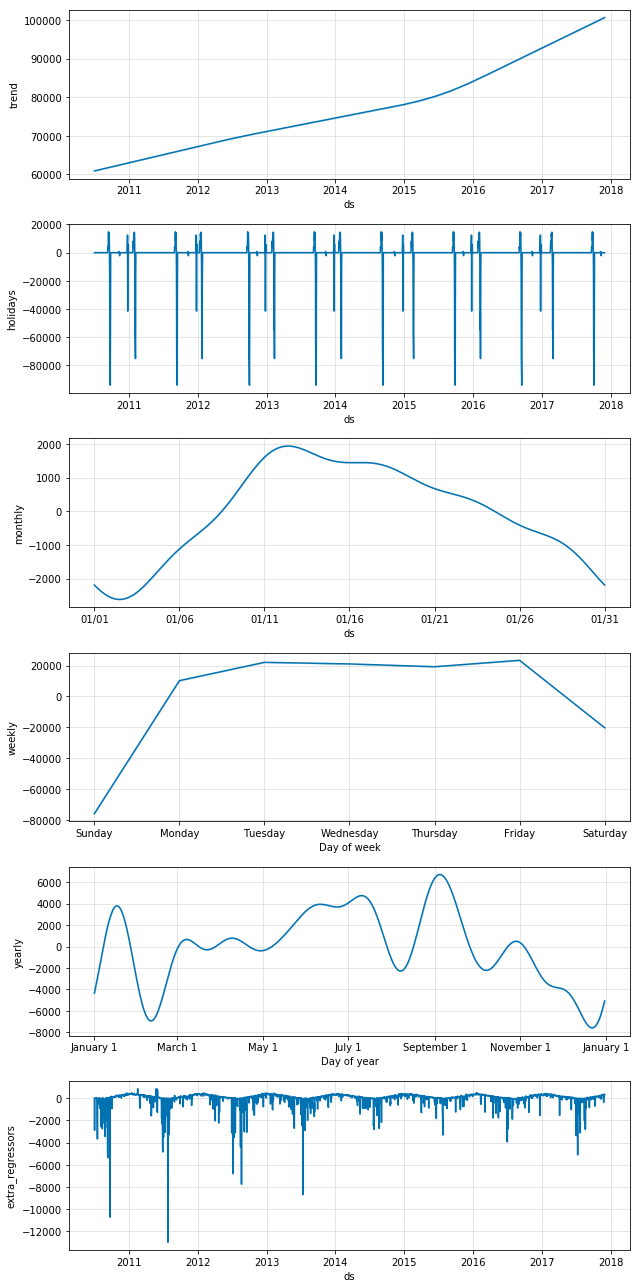

In [22]:
result_dict['y']['model'].plot_components(result_dict['y']['forecastProphetTable'])